In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
from scipy.integrate import ode, solve_ivp
sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Protocols')
from pacing_protocol import PacingProtocol
import mod_protocols
sys.path.append('../models')
from Models.ord2011 import ORD2011

In [3]:
import simulator_scipy
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

model = ORD2011()
sim_bdf = simulator_scipy.Simulator(model)

sim_bdf.pre_simulate( pre_step=5000 )                 
print("Pre-simulation has been completed.")

Pre-simulation has been completed.


In [4]:
'''
Simulation with BDF
'''
simulated_models_BDF = []
for name, mode in cells.items(): 
    start_time = time.time()
    
    model.cell.mode = mode
    model.protocol = PacingProtocol(level=1, start=20, length=0.5, period=1000, multiplier=0, default_time_unit='ms')
    t_span = (0, 500)
    t_eval = np.linspace(0, t_span[1], 5000)  
    sim_bdf.simulate(t_span=t_span, t_eval=t_eval, method='BDF', max_step=0.5, atol=1e-06, rtol=1e-06)       
    simulated_models_BDF.append(copy.copy(model))
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 2.0800998210906982 seconds ---
--- 2.106285333633423 seconds ---
--- 2.2048580646514893 seconds ---


In [5]:
import simulator_euler
'''
Simulation with Euler
'''
sim_euler = simulator_euler.Simulator(model)
simulated_models_Euler = []
for name, mode in cells.items(): 
    start_time = time.time()
    
    model.cell.mode = mode
    model.protocol = PacingProtocol(level=1, start=20, length=0.5, period=1000, multiplier=0, default_time_unit='ms')
    
    sim_euler.dt = 0.02 
    sim_euler.simulate(end_time=500)      
    simulated_models_Euler.append(copy.copy(model))
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 7.867508411407471 seconds ---
--- 7.964452505111694 seconds ---
--- 7.972437143325806 seconds ---


In [6]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011.mmt" 

sim_myokit = simulator_myokit.Simulator(model_path, pre_sim=1) 
sim_myokit.name = "ORD2011"
times = np.linspace(0,500, 5000)
sim_myokit.bcl = 1000

simulated_models_myokit = []
for name, mode in cells.items():    
    start_time = time.time()
    
    sim_myokit.simulation.set_constant('cell.mode', mode)    
    d = sim_myokit.simulate(times)
    simulated_models_myokit.append(d)
    
    print("--- %s seconds ---"%(time.time()-start_time))

--- 0.5936794281005859 seconds ---
--- 0.5726563930511475 seconds ---
--- 0.764714241027832 seconds ---


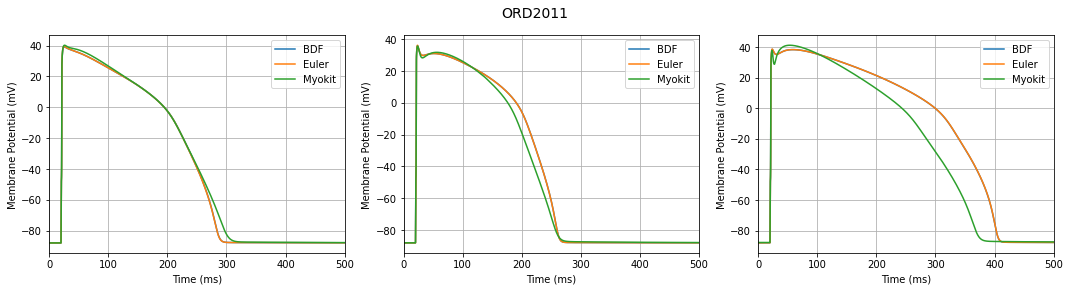

In [7]:
'''
Plot
'''
fig, axes = plt.subplots(1,3, figsize=(18,4))    
fig.suptitle(model.name, fontsize=14)
for name, mode in cells.items(): 
    bdf = simulated_models_BDF[mode]
    euler = simulated_models_Euler[mode]
    myokit = simulated_models_myokit[mode]
    
    # ax.set_title('Simulation %d'%(simulationNo))
    axes[mode].set_xlim(bdf.times.min(), bdf.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[mode].set_ylabel('Membrane Potential (mV)')  
    axes[mode].set_xlabel('Time (ms)')       
    
    axes[mode].plot(bdf.times, bdf.V, label='BDF')   
    axes[mode].plot(euler.times, euler.V, label='Euler')   
    axes[mode].plot( myokit['engine.time'], myokit['membrane.V'], label='Myokit') 
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    axes[mode].legend()
    axes[mode].grid()
    
#     print(bdf.V)
#     print(euler.V)
#     print("-"*100)
    
plt.show()
fig.savefig(os.path.join('Results', "ORD2011"), dpi=100)

In [8]:
print("Complete")

Complete
